Importing libraries:

In [1]:
import trimesh
import numpy as np

Loading nut and screw objects which will be used in the rest of the task:

In [2]:
mesh_screw = trimesh.load_mesh("screw.stl")
mesh_nut = trimesh.load_mesh("nut.stl")

In [3]:
mesh_screw.show()

In [4]:
mesh_nut.show()

###  Task 1

The first task is to place the nut below the screw head. To do so, we need to find out what is the height of the screw head and with that information we can translate the nut on the z-axis for the calculated amount. Using information about each object centroid we can place them in the same starting position and from there we can proceed with the task.

In [5]:
box = mesh_screw.bounds
delete_box = trimesh.creation.box(bounds=[[14, 0, box[0,2]], [20, 1, box[1,2]]])
temp = trimesh.util.concatenate([mesh_screw, delete_box])
result_mesh = mesh_screw.intersection(delete_box)

off_z = result_mesh.bounds[1,2] - result_mesh.bounds[0,2]

The next few cells will give general solution to our height of the screw head problem.
Let's create a 2D slice of the screw:

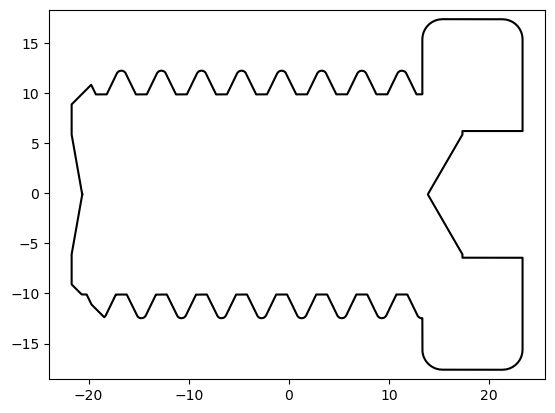

In [6]:
slice = mesh_screw.section(plane_origin=mesh_screw.centroid, plane_normal=[1,1,0])

slice_2D, to_3D = slice.to_planar()
slice_2D.show()

We observe only "upper" part of the slice since the screw is symmetrical. The goal is to find only vertical lines, and then take two lines that represent upper and lower bound of the screw head and calculate their distance.

In [7]:
mask = slice_2D.vertices[:,1] > 0
slice_2D.explode()
temp = set()
for line in slice_2D.entities:
    points = line.points
    gt_0 = mask[points]
    if np.sum(gt_0) < 2:
        continue
    point_coords = slice_2D.vertices[points]
    diff = point_coords[0] - point_coords[1]
    if abs(diff[0]) <= 1e-8:
        temp.add(np.round(point_coords[0,0],4))
temp = sorted(temp)
offset = temp[-1] - temp[1]

We have screw head height and centroids. All we have to do now is position both objects in the same place (origin) and then translate nut under the screw head. Final result of the first task is shown below.

In [8]:
screw_box = mesh_screw.bounds
nut_box = mesh_nut.bounds
screw_centroid = mesh_screw.centroid
nut_centroid = mesh_nut.centroid
screw_translation_vector = [screw_centroid[0]*(-1), screw_centroid[1]*(-1), 0]
nut_translation_vector = [nut_centroid[0]*(-1), nut_centroid[1]*(-1), off_z]
mesh_nut.apply_translation(nut_translation_vector)
mesh_screw.apply_translation(screw_translation_vector)
combined_mesh = trimesh.util.concatenate([mesh_screw, mesh_nut])
combined_mesh.show()

### Task 2

The second task is to place the nut below the screw head and to cut off the excess screw tail. From nut's bounds we can find out what is the height of the nut. Knowing the height of the nut and screw head we can easily define the height of the box which will be used as a mask to obtain wanted object. To create mask box we will use sum of obtained heights and bounds of previously created object in task 1. Final result of the second task is shown below.

In [9]:
screw_box = mesh_screw.bounds
nut_box = mesh_nut.bounds
box = combined_mesh.bounds
mask_box = trimesh.creation.box(bounds=[box[0,:], [box[1,0], box[1,1], off_z + nut_box[1,2] - nut_box[0,2]]])
combined_mesh_2 = combined_mesh.intersection(mask_box)
combined_mesh_2.show()

### Task 3

The third task is to make the nut completely cover the screw. To do so we need to scale the nut on the z-axis and make it same the same height as the screw tail height. Scale factor is calculated as a quotient of screw tail height and nut height. Both heights can be calculated from the aforementioned bounds. After scaling nut to get wanted height we can translate nut under the screw head again and show the final result.

In [10]:
scale_factor = (screw_box[1,2]-off_z)/(nut_box[1,2] - nut_box[0,2])
nut_translation_vector = [nut_centroid[0]*(-1), nut_centroid[1]*(-1), -off_z]
mesh_nut.apply_translation(nut_translation_vector)
mesh_nut.apply_scale([1,1,scale_factor])
nut_translation_vector = [nut_centroid[0]*(-1), nut_centroid[1]*(-1), off_z]
mesh_nut.apply_translation(nut_translation_vector)
combined_mesh_3 = trimesh.util.concatenate([mesh_screw, mesh_nut])
combined_mesh_3.show()